In [1]:
!ls

0213-chatbot.ipynb  data


### Step 2. 데이터 전처리하기

In [2]:
import os
import pandas as pd

datapath = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(datapath)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- 데이터 개수

In [3]:
len(data)

11823

In [4]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [5]:
import re

# 전처리 함수
def preprocess_sentence(sentence):
  # 단어와 구두점(punctuation) 사이의 공백 추가
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  # 연속된 공백을 하나의 공백으로 전환
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.strip()
  return sentence

In [6]:
data['Q'][0]

'12시 땡!'

In [7]:
preprocess_sentence(data['Q'][0])

'12시 땡 !'

In [8]:
data['clean_q'] = data['Q'].apply(lambda x : preprocess_sentence(x))
data['clean_a'] = data['A'].apply(lambda x : preprocess_sentence(x))

In [9]:
data.head()

,Q,A,label,clean_q,clean_a
0,12시 땡!,하루가 또 가네요.,0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다.,0,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,PPL 심하네,눈살이 찌푸려지죠.,0,PPL 심하네,눈살이 찌푸려지죠 .


In [10]:
questions = data['clean_q']
answers = data['clean_a']
questions, answers

(0                         12시 땡 !
 1                     1지망 학교 떨어졌어
 2                    3박4일 놀러가고 싶다
 3                 3박4일 정도 놀러가고 싶다
 4                         PPL 심하네
                    ...           
 11818             훔쳐보는 것도 눈치 보임 .
 11819             훔쳐보는 것도 눈치 보임 .
 11820                흑기사 해주는 짝남 .
 11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
 11822                  힘들어서 결혼할까봐
 Name: clean_q, Length: 11823, dtype: object,
 0                      하루가 또 가네요 .
 1                       위로해 드립니다 .
 2                     여행은 언제나 좋죠 .
 3                     여행은 언제나 좋죠 .
 4                      눈살이 찌푸려지죠 .
                    ...            
 11818          티가 나니까 눈치가 보이는 거죠 !
 11819               훔쳐보는 거 티나나봐요 .
 11820                      설렜겠어요 .
 11821    잘 헤어질 수 있는 사이 여부인 거 같아요 .
 11822          도피성 결혼은 하지 않길 바라요 .
 Name: clean_a, Length: 11823, dtype: object)

### Step 3. SubwordTextEncoder 사용하기 (단어장 만들기)

In [12]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

In [13]:
# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [14]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('단어장의 크기 :',VOCAB_SIZE)

START_TOKEN의 번호 : [8364]
END_TOKEN의 번호 : [8365]
단어장의 크기 : 8366


#### 정수 인코딩 & 패딩

In [15]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5829, 605, 2500, 4174]
정수 인코딩 후의 21번째 답변 샘플: [2685, 7669, 8, 6378, 95, 1]


In [16]:
# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(questions[21])
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(answers[21])
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5829, 605, 2500, 4174]
기존 문장: 가스비 장난 아님
정수 인코딩 후의 문장 [2685, 7669, 8, 6378, 95, 1]
기존 문장: 다음 달에는 더 절약해봐요 .


In [17]:
questions[0]

'12시 땡 !'

In [18]:
import tensorflow as tf

# 최대 길이를 40으로 정의
MAX_LENGTH = 40

def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [19]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))
questions.shape, answers.shape

단어장의 크기 : 8366
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


((11823, 40), (11823, 40))

#### Teacher forcing 사용하기

In [20]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용
# 이에 따라 outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 마지막 패딩 토큰 제거
    },
    {
        'outputs': answers[:, 1:]  # 시작 토큰이 제거
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기

- PositionalEncoding

In [24]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    # angle_rads = np.zeros(angle_rads.shape)
    # angle_rads[:, 0::2] = sines
    # angle_rads[:, 1::2] = cosines
    # pos_encoding = tf.constant(angle_rads)

    pos_encoding = pos_encoding[tf.newaxis, ...]

    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

- MultiHeadAttention

In [31]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

- create_padding_mask & create_look_ahead_mask

In [29]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  # 룩어헤드 마스크
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  # 패딩 마스크
  padding_mask = create_padding_mask(x)
  # 마스크 두 개 합치기
  return tf.maximum(look_ahead_mask, padding_mask)

- Encoder

In [30]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

- Decoder

In [32]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

- Transformer

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 모델 생성

- 빠른 버전 vs 논문버전(num_layers는 6, d-Model은 512)

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3195904     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

- Loss function

In [35]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

- Custom Learning rate

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- Model compile

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

- Train model

In [46]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 10s 52ms/step - loss: 0.4271 - accuracy: 0.1042
Epoch 2/50
185/185 [==============================] - 10s 53ms/step - loss: 0.3459 - accuracy: 0.1155
Epoch 3/50
185/185 [==============================] - 10s 52ms/step - loss: 0.2709 - accuracy: 0.1263
Epoch 4/50
185/185 [==============================] - 10s 52ms/step - loss: 0.2054 - accuracy: 0.1366
Epoch 5/50
185/185 [==============================] - 10s 52ms/step - loss: 0.1513 - accuracy: 0.1459
Epoch 6/50
185/185 [==============================] - 10s 52ms/step - loss: 0.1092 - accuracy: 0.1533
Epoch 7/50
185/185 [==============================] - 10s 53ms/step - loss: 0.0795 - accuracy: 0.1589
Epoch 8/50
185/185 [==============================] - 10s 53ms/step - loss: 0.0612 - accuracy: 0.1622
Epoch 9/50
185/185 [==============================] - 10s 53ms/step - loss: 0.0508 - accuracy: 0.1640
Epoch 10/50
185/185 [==============================] - 10s 53ms/step - loss: 0.045

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Step 5. 모델 평가하기

In [62]:
def decoder_inference(sentence, custom_model):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = custom_model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [64]:
def sentence_generation(sentence, custom_model):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence, custom_model)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}\n'.format(predicted_sentence))

  return predicted_sentence

In [65]:
sentence_generation('아 심심해', model)

입력 : 아 심심해
출력 : 노래 불러 드릴까요 ? 북치기박치기 헥헥



'노래 불러 드릴까요 ? 북치기박치기 헥헥'

In [42]:
sentence_generation('어 너무 싫어', model)

입력 : 어 너무 싫어
출력 : 잠시 눈을 감고 휴식을 취해보세요 .


'잠시 눈을 감고 휴식을 취해보세요 .'

In [45]:
test_questions = [
    '안녕하세요~~~',
    '아 퇴근 시간 언제야?',
    '왤케 시간이 안 가냐 ㅠ',
    '집에 가고 싶다',
    '몇 시에 만날래?',
    '근황 토크 좀 하자',
    '거기 개쩌는데잖아',
    '나는 헬스를 다니니까',
    '니 이제 인났나?',
    '뭐고?',
    '잤나?'
]

for test in test_questions:
    sentence_generation(test)

입력 : 안녕하세요~~~
출력 : 아직 많이 지쳤나봐요 .

입력 : 아 퇴근 시간 언제야?
출력 : 그래도 먹으려고 노력해보세요 .

입력 : 왤케 시간이 안 가냐 ㅠ
출력 : 그 사람도 그럴 거예요 .

입력 : 집에 가고 싶다
출력 : 맛있게 드세요 .

입력 : 몇 시에 만날래?
출력 : 시간 있냐고 물어보세요 .

입력 : 근황 토크 좀 하자
출력 : 잠시 눈을 감고 휴식을 취해보세요 .

입력 : 거기 개쩌는데잖아
출력 : 새로운 데이트 신청 해보세요 .

입력 : 나는 헬스를 다니니까
출력 : 그 사람도 그럴 수 있어요 .

입력 : 니 이제 인났나?
출력 : 그 사람을 잊는다는 건 어떨까요 .

입력 : 뭐고?
출력 : 저는 위로해드리는 로봇이에요 .

입력 : 잤나?
출력 : 사랑은 소유하는 게 아니에요 .



**50 Epochs** 

In [47]:
for test in test_questions:
    sentence_generation(test)

입력 : 안녕하세요~~~
출력 : 안녕하세요 .

입력 : 아 퇴근 시간 언제야?
출력 : 째깍째깍 .

입력 : 왤케 시간이 안 가냐 ㅠ
출력 : 다른 남자는 만나봐야 알죠 .

입력 : 집에 가고 싶다
출력 : 집이 최고죠 .

입력 : 몇 시에 만날래?
출력 : 사랑은 안 변하고 사람이 변해요 .

입력 : 근황 토크 좀 하자
출력 : 꾸준히 연락을 하는게 필요합니다 .

입력 : 거기 개쩌는데잖아
출력 : 세다고 너무 많이 드시면 안돼요 .

입력 : 나는 헬스를 다니니까
출력 : 시간이 벌써 흘렀네요 .

입력 : 니 이제 인났나?
출력 : 최신 영화가 좋을 것 같아요 .

입력 : 뭐고?
출력 : 저는 위로봇입니다 .

입력 : 잤나?
출력 : 잠이 정말 중요해요 . 눈을 좀 붙이세요 .



In [49]:
wellness_questions = [
    "나 요즘 너무 지쳤어. 어떻게 해야 할까?",
    "내가 잘하고 있는지 모르겠어.",
    "아무리 노력해도 결과가 안 좋아. 나한테 문제가 있는 걸까?",
    "사람들이 날 싫어하는 것 같아.",
    "계속 실패만 해. 포기해야 할까?",
    "누군가에게 기대고 싶은데, 그럴 사람이 없어.",
    "내 이야기를 들어주는 사람이 없어서 외로워.",
    "열심히 하는데도 인정받지 못하는 기분이야.",
    "나는 왜 이렇게 부족할까?",
    "다들 행복해 보이는데, 나만 힘든 것 같아.",
    "내 미래가 불안해서 걱정돼.",
    "오늘 너무 힘든 일이 있었어. 위로가 필요해.",
    "무기력하고 아무것도 하기 싫어.",
    "나는 왜 항상 남들보다 뒤처지는 느낌이지?",
    "요즘 너무 스트레스 받아서 견디기 힘들어."
]

for test in wellness_questions:
    sentence_generation(test)

입력 : 나 요즘 너무 지쳤어. 어떻게 해야 할까?
출력 : 세상에는 흥미로운 일이 많은걸요 .

입력 : 내가 잘하고 있는지 모르겠어.
출력 : 더 열심히 노력하겠습니다 .

입력 : 아무리 노력해도 결과가 안 좋아. 나한테 문제가 있는 걸까?
출력 : 다른 사람이 답답할 거예요 .

입력 : 사람들이 날 싫어하는 것 같아.
출력 : 좀 더 호감을 표현해보세요 .

입력 : 계속 실패만 해. 포기해야 할까?
출력 : 더 좋은 사람 만날 거예요 .

입력 : 누군가에게 기대고 싶은데, 그럴 사람이 없어.
출력 : 쉬운 일이 아니긴 하죠 .

입력 : 내 이야기를 들어주는 사람이 없어서 외로워.
출력 : 조금 더 사랑해보세요 .

입력 : 열심히 하는데도 인정받지 못하는 기분이야.
출력 : 다음에는 잘 될 거예요 .

입력 : 나는 왜 이렇게 부족할까?
출력 : 더 노력해보세요 .

입력 : 다들 행복해 보이는데, 나만 힘든 것 같아.
출력 : 자신만 행복하면 돼요 .

입력 : 내 미래가 불안해서 걱정돼.
출력 : 또 다른 미래가 펼쳐질 거예요 .

입력 : 오늘 너무 힘든 일이 있었어. 위로가 필요해.
출력 : 너무 힘들게 하는 사실이네요 .

입력 : 무기력하고 아무것도 하기 싫어.
출력 : 자신의 감정을 주변 사람들에게 터놓고 이야기해보세요 .

입력 : 나는 왜 항상 남들보다 뒤처지는 느낌이지?
출력 : 정신 차리세요 .

입력 : 요즘 너무 스트레스 받아서 견디기 힘들어.
출력 : 운동을 해보세요 .



**페이퍼 모델 테스트**  (num_layers는 6, d-Model은 512)

In [50]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

paper_model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

paper_model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13751296    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [51]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

paper_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [52]:
EPOCHS = 10
history = paper_model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
185/185 [==============================] - 54s 207ms/step - loss: 1.3523 - accuracy: 0.0234
Epoch 2/10
185/185 [==============================] - 39s 211ms/step - loss: 1.0748 - accuracy: 0.0495
Epoch 3/10
185/185 [==============================] - 40s 214ms/step - loss: 0.9833 - accuracy: 0.0508
Epoch 4/10
185/185 [==============================] - 40s 217ms/step - loss: 0.9407 - accuracy: 0.0529
Epoch 5/10
185/185 [==============================] - 40s 218ms/step - loss: 0.9059 - accuracy: 0.0552
Epoch 6/10
185/185 [==============================] - 40s 218ms/step - loss: 0.8704 - accuracy: 0.0569
Epoch 7/10
185/185 [==============================] - 40s 218ms/step - loss: 0.8311 - accuracy: 0.0591
Epoch 8/10
185/185 [==============================] - 40s 218ms/step - loss: 0.7840 - accuracy: 0.0619
Epoch 9/10
185/185 [==============================] - 40s 218ms/step - loss: 0.7334 - accuracy: 0.0655
Epoch 10/10
185/185 [==============================] - 40s 217ms/step - l

In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

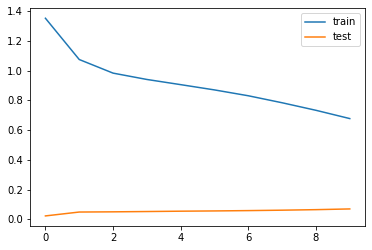

In [59]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['accuracy'], label='test')
plt.legend()
plt.show()

In [66]:
for test in test_questions:
    sentence_generation(test, paper_model)

입력 : 안녕하세요~~~
출력 : 좋은 사람 만날 거예요 .

입력 : 아 퇴근 시간 언제야?
출력 : 저는 잘 될 거예요 .

입력 : 왤케 시간이 안 가냐 ㅠ
출력 : 이제 좀 더 괜찮아졌길 바랄게요 .

입력 : 집에 가고 싶다
출력 : 맛있게 드세요 .

입력 : 몇 시에 만날래?
출력 : 직접 물어보세요 .

입력 : 근황 토크 좀 하자
출력 : 좋은 사람 만날 수 있을 거예요 .

입력 : 거기 개쩌는데잖아
출력 : 잘 되길 바랄게요 .

입력 : 나는 헬스를 다니니까
출력 : 좋은 사람 만날 수 있을 거예요 .

입력 : 니 이제 인났나?
출력 : 직접 물어보세요 .

입력 : 뭐고?
출력 : 같이 가보세요 .

입력 : 잤나?
출력 : 저도 좋아해요 .



In [67]:
for test in wellness_questions:
    sentence_generation(test, paper_model)

입력 : 나 요즘 너무 지쳤어. 어떻게 해야 할까?
출력 : 혼자 사는 것도 좋을 것 같아요 .

입력 : 내가 잘하고 있는지 모르겠어.
출력 : 잘 될 거예요 .

입력 : 아무리 노력해도 결과가 안 좋아. 나한테 문제가 있는 걸까?
출력 : 직접 물어보세요 .

입력 : 사람들이 날 싫어하는 것 같아.
출력 : 이제 좀 괜찮아졌길 바랄게요 .

입력 : 계속 실패만 해. 포기해야 할까?
출력 : 직접 물어보세요 .

입력 : 누군가에게 기대고 싶은데, 그럴 사람이 없어.
출력 : 마음이 복잡하겠어요 .

입력 : 내 이야기를 들어주는 사람이 없어서 외로워.
출력 : 직접 물어보세요 .

입력 : 열심히 하는데도 인정받지 못하는 기분이야.
출력 : 잘 될 거예요 .

입력 : 나는 왜 이렇게 부족할까?
출력 : 혼자 사는 것도 좋을 것 같아요 .

입력 : 다들 행복해 보이는데, 나만 힘든 것 같아.
출력 : 그 사람도 가장 가장 가장 좋은 사람 만날 수 있을 거예요 .

입력 : 내 미래가 불안해서 걱정돼.
출력 : 그 사람도 그럴 거예요 .

입력 : 오늘 너무 힘든 일이 있었어. 위로가 필요해.
출력 : 잘 될 거예요 .

입력 : 무기력하고 아무것도 하기 싫어.
출력 : 직접 물어보세요 .

입력 : 나는 왜 항상 남들보다 뒤처지는 느낌이지?
출력 : 직접 물어보는 건 어떨까요 .

입력 : 요즘 너무 스트레스 받아서 견디기 힘들어.
출력 : 좋은 생각이에요 .



In [ ]:
EPOCHS = 50
history = paper_model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 38s 206ms/step - loss: 0.6184 - accuracy: 0.0765
Epoch 2/50
185/185 [==============================] - 39s 210ms/step - loss: 0.5594 - accuracy: 0.0832
Epoch 3/50
185/185 [==============================] - 39s 213ms/step - loss: 0.5023 - accuracy: 0.0902
Epoch 4/50
185/185 [==============================] - 40s 216ms/step - loss: 0.4460 - accuracy: 0.0973
Epoch 5/50
185/185 [==============================] - 40s 219ms/step - loss: 0.3976 - accuracy: 0.1037
Epoch 6/50
185/185 [==============================] - 40s 217ms/step - loss: 0.3536 - accuracy: 0.1098
Epoch 7/50
185/185 [==============================] - 40s 218ms/step - loss: 0.3199 - accuracy: 0.1139
Epoch 8/50
185/185 [==============================] - 40s 217ms/step - loss: 0.2914 - accuracy: 0.1174
Epoch 9/50
185/185 [==============================] - 40s 217ms/step - loss: 0.2705 - accuracy: 0.1201
Epoch 10/50
185/185 [==============================] - 40s 217ms/step - l

In [69]:
for test in test_questions:
    sentence_generation(test, paper_model)

입력 : 안녕하세요~~~
출력 : 많이 힘들지 않길 바라요 .

입력 : 아 퇴근 시간 언제야?
출력 : 절대 능력만 중요하지 않아요 .

입력 : 왤케 시간이 안 가냐 ㅠ
출력 : 말조심하세요 .

입력 : 집에 가고 싶다
출력 : 즐거운 시간 보내시길 바랍니다 .

입력 : 몇 시에 만날래?
출력 : 일단 연락처를 주고 받고 부담스럽지 않는 선에서 친해지는게 좋아요 .

입력 : 근황 토크 좀 하자
출력 : 답답한 상황이네요 .

입력 : 거기 개쩌는데잖아
출력 : 아이구 .

입력 : 나는 헬스를 다니니까
출력 : 결정은 그대의 몫입니다 .

입력 : 니 이제 인났나?
출력 : 후폭풍은 누구에게나 올 거예요 .

입력 : 뭐고?
출력 : 나랑 같이 놀아요 .

입력 : 잤나?
출력 : 이해하기 힘드니까요 .



In [70]:
for test in wellness_questions:
    sentence_generation(test, paper_model)

입력 : 나 요즘 너무 지쳤어. 어떻게 해야 할까?
출력 : 한푼 두푼 차곡차곡차곡

입력 : 내가 잘하고 있는지 모르겠어.
출력 : 잘하고 있다고 괜찮다고 스스로에게 말해보세요 .

입력 : 아무리 노력해도 결과가 안 좋아. 나한테 문제가 있는 걸까?
출력 : 안 만나는 게 마음이 편할 거예요 .

입력 : 사람들이 날 싫어하는 것 같아.
출력 : 감성적이기 딱 좋죠 .

입력 : 계속 실패만 해. 포기해야 할까?
출력 : 시간이 필요한 것 같아요 .

입력 : 누군가에게 기대고 싶은데, 그럴 사람이 없어.
출력 : 나이에 상관이 없죠 .

입력 : 내 이야기를 들어주는 사람이 없어서 외로워.
출력 : 지난 기대에 연연연연해하지 마세요 .

입력 : 열심히 하는데도 인정받지 못하는 기분이야.
출력 : 살 안 찌는 게 좋을 것 같아요 .

입력 : 나는 왜 이렇게 부족할까?
출력 : 지금보다 더 잘 살 거예요 .

입력 : 다들 행복해 보이는데, 나만 힘든 것 같아.
출력 : 새로운 일을 경험해 보세요 .

입력 : 내 미래가 불안해서 걱정돼.
출력 : 사는 재미가 없을거예요 .

입력 : 오늘 너무 힘든 일이 있었어. 위로가 필요해.
출력 : 지금 딱 힘들 거예요 .

입력 : 무기력하고 아무것도 하기 싫어.
출력 : 자신의 몸값을 올려보세요 .

입력 : 나는 왜 항상 남들보다 뒤처지는 느낌이지?
출력 : 조급하게 생각하지 말아요 .

입력 : 요즘 너무 스트레스 받아서 견디기 힘들어.
출력 : 저에게 기대세요 .



In [71]:
import numpy as np

def get_text_len(rows):
  rows_len = [len(s.split()) for s in rows]
  print('최소 길이 : {}'.format(np.min(rows_len)))
  print('최대 길이 : {}'.format(np.max(rows_len)))
  print('평균 길이 : {}'.format(np.mean(rows_len)))
  return rows_len

In [73]:
q = data['clean_q']
a = data['clean_a']
q, a

(0                         12시 땡 !
 1                     1지망 학교 떨어졌어
 2                    3박4일 놀러가고 싶다
 3                 3박4일 정도 놀러가고 싶다
 4                         PPL 심하네
                    ...           
 11818             훔쳐보는 것도 눈치 보임 .
 11819             훔쳐보는 것도 눈치 보임 .
 11820                흑기사 해주는 짝남 .
 11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
 11822                  힘들어서 결혼할까봐
 Name: clean_q, Length: 11823, dtype: object,
 0                      하루가 또 가네요 .
 1                       위로해 드립니다 .
 2                     여행은 언제나 좋죠 .
 3                     여행은 언제나 좋죠 .
 4                      눈살이 찌푸려지죠 .
                    ...            
 11818          티가 나니까 눈치가 보이는 거죠 !
 11819               훔쳐보는 거 티나나봐요 .
 11820                      설렜겠어요 .
 11821    잘 헤어질 수 있는 사이 여부인 거 같아요 .
 11822          도피성 결혼은 하지 않길 바라요 .
 Name: clean_a, Length: 11823, dtype: object)

In [74]:
q_len = get_text_len(q)
a_len = get_text_len(a)

최소 길이 : 1
최대 길이 : 16
평균 길이 : 3.9402858834475176
최소 길이 : 1
최대 길이 : 24
평균 길이 : 4.71589275141673


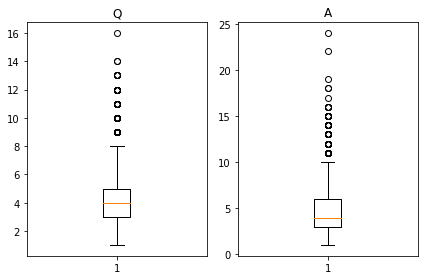

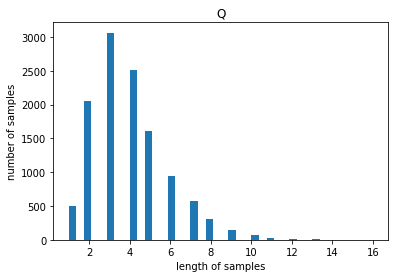

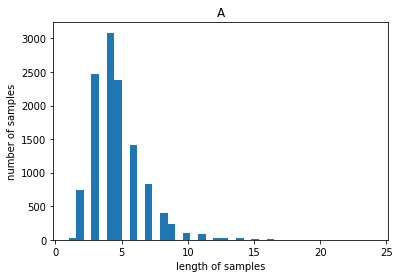

In [75]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.boxplot(q_len)
plt.title('Q')
plt.subplot(1,2,2)
plt.boxplot(a_len)
plt.title('A')
plt.tight_layout()
plt.show()

plt.title('Q')
plt.hist(q_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('A')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 회고
#### 실험 하이퍼파라미터
- Layer 개수와 차원 수
  1. `NUM_LAYERS = 2`, `D_MODEL = 256`
  2. `NUM_LAYERS = 6`, `D_MODEL = 512`
- EPOCHS
  1. 10
  2. 50
- 시간 관계상 논문에 나온 하이퍼파라미터가 아닌 적은 수를 썼다고 해서 비교해 봄
  - 근데 의외로 성능이 제일 좋은 건 1 + 2의 조합 (`NUM_LAYERS = 2`, `D_MODEL = 256`, `EPOCHS = 50`)
- 데이터의 최대 길이랑 평균 길이를 출력해 봤는데 평균 길이 자체가 굉장히 짧음
    ```
    최소 길이 : 1
    최대 길이 : 16
    평균 길이 : 3.9402858834475176
    최소 길이 : 1
    최대 길이 : 24
    평균 길이 : 4.71589275141673
    ```
  - 데이터가 단순한데 페이퍼 모델을 너무 복잡해서 그럴 수도..
- 또, 한국어가 형태소 위주로 끊어야 되는데, 그게 아니라 많은 정보가 손실 됐을 수도..
- `MAX_LENGTH = 40`으로 했는데 이유를 생각해보니,
  - 일단 트랜스포머는 병렬로 들어가니깐 문장들을 최대한 살리기 위함
  - 디코더가 생성하는 문장도 역시 해당 파라미터를 고려하니 어색하지 않게 문장을 생성하기 위함
- 따라서 해 볼 추가 실험
  1. `MAX_LENGTH` 조절해보기
  2. 형태소로 자르는거 해보기




